# Descripció del cristall de BN

```{note}
En este notebook va la major part del codi. De fet és on estan tots els càlculs.
```

In [1]:
# Netejem totes les variables 
reset()

In [2]:
# Eixida per defecte en LaTeX. Nota: en firefox cambiar "Math Renderer a Mathml" per visualitzar millor tant la web com el notebook. 
%display latex

# Importe les biblioteques i mètodes que empre al llarg de l'script
from pylab import loadtxt
import pandas as pd

import numpy
from numpy import arange
#from myst_nb import glue

# Defineisc algunes funcions que empraré més endavant
def matriu_simplificada(matriu,m,n):
    matsimp=matriu
    for i in range(m):
        for j in range(n):
             matsimp[i,j]=matriu[i,j].full_simplify()
    
    return matsimp

Donat que el càlcul dels modes de vibració comença per establir la geomeria del cristall en equilibri, comprobem que el $BN$ monocapa es tracta d'un cristall bidimensional hexagonal de base diatómica la cel·la unitat del qual ve donada per (dades proporcionades):

$$
\vec a_1=a(1,0);\qquad\vec a_2=a\left(-\frac{1}{2},\frac{\sqrt{3}}{2}\right);
$$

In [3]:
var('a', domain='positive')
a_1=a*vector([1,0])
a_2=a*vector([-1/2,sqrt(3)/2])

Comprobem que efectivament els dos vectors base formen un angle de

In [4]:
angle=arccos(a_1*a_2/(norm(a_1)*norm(a_2)))
#glue("angle_cela", angle, display=False)
show(angle, " radians")
#In-line text; {glue:}`angle`

2/3*pi ' radians'

Numerem les cel·les unitat amb un índex vectorial $\vec l=\left( l_1, l_2\right)$.


Les posicions dels nucs són $\vec R_{\vec l}=l_1\vec{a}_1+l_2\vec{a}_2$<p>
Visualitzem una regió de la xarxa hexagonal, amb els corresponents nucs (que no àtoms), així com la corresponent cel·la unitat,

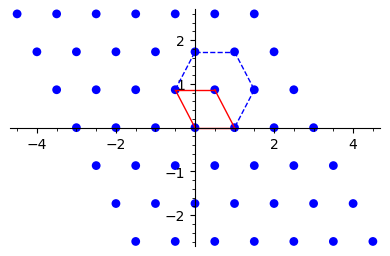

In [5]:
nucs=points([l_1*a_1/a+l_2*a_2/a for l_1 in range(-3, 4) for l_2 in range(-3,4)], 
             size=40, color="blue", frame=False)

show(nucs+
    line([(0,0),(a_1/a)],color="red")+
     line([(0,0),(a_2/a)],color="red")+
     line([(a_1/a),(a_1/a+a_2/a)],color="red")+
     line([(a_2/a),(a_2/a+a_1/a)],color="red")+
     line([(a_2/a),(a_1/a+2*a_2/a)],linestyle="--")+
     line([(a_1/a+2*a_2/a),(2*a_1/a+2*a_2/a)],linestyle="--")+
     line([(2*a_1/a+2*a_2/a),(2*a_1/a+a_2/a)],linestyle="--")+
     line([(2*a_1/a+a_2/a),(a_1/a)],linestyle="--"), figsize=4)

Les posicions atòmiques d'equilibri en la cel·la unitat són (també proporcionades com a dades):

$$
\vec R_B=\frac{1}{3}\vec{a_1}+2\vec{a_2}\qquad
\vec R_N=\frac{2}{3}\vec{a_1}+\frac{1}{3}\vec{a_2}
$$

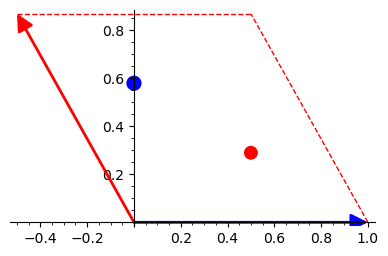

In [6]:
r_B=1/3*a_1+2/3*a_2; r_N=2/3*a_1+1/3*a_2
show(arrow((0,0),(a_1/a),color="blue")+
      arrow((0,0),(a_2/a),color="red")+
      line([(a_1/a),(a_1/a+a_2/a)],linestyle="--",color="red")+
      line([(a_2/a),(a_2/a+a_1/a)],linestyle="--",color="red")+
      point(r_B/a, size=120,color="blue")+
      point(r_N/a, size=100,color="red"), frame=False, figsize=4)

## Identificació dels veins segons la seua distància

Per construir la matriu dinàmica necessitem com a pas previ classificar el átoms del cristall segons la seua distància als àtoms de la cel·la unitat, ja que els classificarem com primers, segons, tercers ... veïns segons aquesta distància i els assignarem un tensor de constants de forces que dependrá de a quina familia de veïns pertanyen.

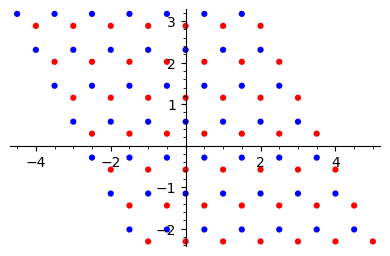

In [7]:

#Posicins d'equilibri dels àtoms
def RB(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_B)

def RN(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_N)

AtomosB=points([RB(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='blue')
AtomosN=points([RN(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='red')

show(AtomosB+AtomosN, figsize=4)

In [8]:
var('q_x, q_y',domain='positive'); q=vector([q_x,q_y])


## Paràmetres de la xarxa, de la cel·la i del cristall

## Vector R_l (vector de translació primitiu)
def R_l(l_1,l_2):
    return l_1*a_1+l_2*a_2

## Vector de posición de los átomos del cristal (en equilibrio)
def R_alpha_l(alpha,l_1,l_2):
    if alpha == 1:
        return l_1*a_1+l_2*a_2+r_B

    elif alpha == 2:
        return l_1*a_1+l_2*a_2+r_N

    else:
        print("Error, alpha solo puede ser 1 o 2 ")

## Vector unitario que une uno de los átomo alphaprima con el átomo considerado alpha, l_1,l_2
def R_hat(alphaprima,alpha,l_1,l_2):
    if (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0)).norm()>0:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))/(R_alpha_l(alpha,l_1,l_2)\
                                                                 -R_alpha_l(alphaprima,0,0)).norm()
    else:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))

# Distancia entre el átomo alphaprime y su vecino alpha situado en la celdilla l_1,l_2
def distancia(alphaprime,alpha,l_1,l_2):
    return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprime,0,0)).norm()/a    

def fase(l_1,l_2):
    return exp(I*q*R_l(l_1,l_2))

#Genero una lista con la distancia de cada átomo a los átomos de la celdilla unidad 
def valores_atomos(l_1, l_2):
    return [(k, m, i, j, R_hat(k, m, i, j), distancia(k,m,i,j)) for k in [1,2] for m in [1,2]  \
      for i in range(-l_1,l_1+1) for j in range(-l_2,l_2+1)]

## Construyo un DataFrame de pandas con la información necesaria para identificar a los primeros, segundos, ... vecinos, según su distancia a cada uno de los átomos de la celdilla unidad
columnas = [r"$\alpha\prime$",r"$\alpha$",r"$l_1$", r"$l_2$", r"$\hat R$",'Distancia']

def lista_atomos(l_1, l_2):
    return pd.DataFrame(valores_atomos(l_1,l_2),columns=columnas).sort_values(['Distancia',r"$\alpha\prime$"], ascending=[True,True])

## Mostramos el dataframe como una tabla
#table(lista_atomos(2,2).to_html(index=False))
table(lista_atomos(2,2).to_html(index=False))

,,,,,Distancia
1,1,0,0,"[0, 0]",0
2,2,0,0,"[0, 0]",0
1,2,-1,0,"[-3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,0,"[3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,1,"[0, sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,-1,"[0, -sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,0,"[-3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,1,0,"[3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,1,-1,-1,"[-1/2, -1/2*sqrt(3)]",1
1,1,-1,0,"[-1, 0]",1


## Tensor de constants de forca i matriu dinàmica

Una vegada descrit el nostre sistema físic anem a obtindre la matriu dinàmica d'aquest, ja que com hem vist els seus valors propis, $\omega^2$, ens donen la freqüència de propagació de cadascun dels modes.

Obtesses les possicions dels àtoms y classificats estos com primers, segons, etc. veïns, segons la distància al respectiu àtom de la cel·la $\vec 0$, procedim a calcular la contribució a la matriu dinàmica de cadascun dels àtoms, per la qual cosa necessitem conèixer el tensor de constants de força que correspon a la interacció de cada àtom amb el seu n-èssim veí.

La forma general del tensor de forces d'un $n$-èssim veí és de la forma  {% cite wirtz04_phonon_disper_graph_revis %} : 


\begin{equation}
C_n=\begin{pmatrix}
\phi_n^1&\xi_n &0\\
-\xi_n & \phi_n^{ti} & 0 \\
0 & 0 & \phi_n^{to}
\end{pmatrix}
\label{eq:tensordeforces}
\end{equation}

on el sistema de coordenadas s'elegeix de manera que $x$ és la coordenada longitudinal (en la línia que conecta els dos àtomos), $y$ la coordenada transversal en el planol i $z$ la coordenada perperndicular al planol. L'estructura diagonal a blocs de la matriu reflexa el fet que las vibracions interplanars y les de fora de plà (en la direcció $z$) estan completament desacoblades.



Anem a supossar (per simplificar) que un desplaçament longitudinal (radial, que estarà contés en el planol del cristall) o transversal (tangencial, siga en el planol o perpendicular al planol) sols genera una força radial o transversal, es a dir, $\xi_n=0$ tal y com es realitza en la referència cite Balkanski 2000. Esta aproximació es coneix com l'aproximació *4NNFC*, i es necessita considerar fins els cuarts veïns per donar compte dels resultats experimentals.

Por tant, com primera aproximació anem a considerar que el tensor de constants de força d'un àtom classificat com $n$-èssim, situat en la direcció $\hat x$ respecte del átom de la cel·la $\vec 0$, té la forma diagonal:

\begin{equation}
C_n=\begin{pmatrix}
\phi_n^r& 0 &0\\
0 & \phi_n^{ti} & 0 \\
0 & 0 & \phi_n^{to}
\end{pmatrix}
\end{equation}

i per tant el tensor de constants de força de cadascun dels $n$-èssims veïns reals l'obtenim rotant esta matriu:
\vspace{4cm}


Un punt important és que quan considerem la interacció entre àtoms del mateix tipus (en el cas del BN és fácil discriminarlos, ja que són àtoms de distints elements els que conformen la base), tenim que considerar la contribució a la matriu dinámica de l'àtom que estem considerant de la cel·la $\vec 0$. Esta contribució podem derivar-la de la condició d'estabilitat, \cite{falkovsky08_symmet_const_phonon_disper_graph}
\cite{wirtz04_phonon_disper_graph_revis}

Si es desplaca el cristall com un tot no canvia l'energía potencial, cosa que implica s'ha de complir:
 
......


Podem tindre en compte altres simetries del cristall per determinar certes propietats del tensor de forces o de la seua transformada de Fourier, la matriu dinàmica (certes relacions entre les components ...) però per ara sols tindrem en compte que la matriu dinàmica es una matri hermítica, i per tant els seus valors propis, $\omega^2$ tenen que ser reals.

In [9]:
#Angle que forma l'àtom considerat respecte a l'eix x

def angulo(alphaprima,alpha,l_1,l_2):
    if R_hat(alphaprima,alpha,l_1,l_2)[1] <0:
        return -acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))
    
    else:
        return acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))

#Matriz unitaria de rotación para cambio de ejes coordenados (entorno al eje z)

def U(theta):
    return matrix([[cos(theta),sin(theta),0], [-sin(theta), cos(theta),0],[0,0,1]])

#Matriz de fuerza para los primeros vecinos

var('M_B,M_N', domain='positive')
var('omega')

phi1rBN=var('phi1rBN',latex_name='\\phi_{1,r}^{BN}',domain='real')
phi1tiBN=var('phi1tiBN',latex_name='\\phi_{1,ti}^{BN}',domain='real')
phi1toBN=var('phi1toBN',latex_name='\\phi_{1,to}^{BN}',domain='real')

phi1rNB=phi1rBN; phi1tiNB=phi1tiBN; phi1toNB=phi1toBN


Phi_10__BN=1/sqrt(M_B*M_N)*Matrix([[phi1rBN,0,0],[0,phi1tiBN,0],[0,0,phi1toBN]])
Phi_10__NB=1/sqrt(M_N*M_B)*Matrix([[phi1rNB,0,0],[0,phi1tiNB,0],[0,0,phi1toNB]])


def Phi_1l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_1l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_10__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_1l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_1l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_1l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_1l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Matriz de fuerza para los segundos vecinos

phi2rBB=var('phi2rBB',latex_name='\\phi_{2,r}^{BB}',domain='real')
phi2tiBB=var('phi2tiBB',latex_name='\\phi_{2,ti}^{BB}',domain='real')
phi2toBB=var('phi2toBB',latex_name='\\phi_{2,to}^{BB}',domain='real')

phi2rNN=var('phi2rNN',latex_name='\\phi_{2,r}^{NN}',domain='real')
phi2tiNN=var('phi2tiNN',latex_name='\\phi_{2,ti}^{NN}',domain='real')
phi2toNN=var('phi2toNN',latex_name='\\phi_{2,to}^{NN}',domain='real')

Phi_20__BB=1/M_B*Matrix([[phi2rBB,0,0],[0,phi2tiBB,0],[0,0,phi2toBB]])
Phi_20__NN=1/M_N*Matrix([[phi2rNN,0,0],[0,phi2tiNN,0],[0,0,phi2toNN]])

#A tener en cuenta: cuando consideramos el mismo tipo de átomos 
# (de la misma subred, no porque sean el mismmo elemento)

def Phi_2l__BB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__BB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_2l__NN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_20__NN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_2l_BB(alphaprima,alpha,l_1,l_2):
    return Phi_2l__BB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_2l_NN(alphaprima,alpha,l_1,l_2):
    return Phi_2l__NN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)


#Matriz de fuerza para los terceros vecinos

phi3rBN=var('phi3rBN',latex_name='\\phi_{3,r}^{BN}',domain='real')
phi3tiBN=var('phi3tiBN',latex_name='\\phi_{3,ti}^{BN}',domain='real')
phi3toBN=var('phi3toBN',latex_name='\\phi_{3,to}^{BN}',domain='real')
phi3rNB,phi3tiNB,phi3toNB=phi3rBN,phi3tiBN,phi3toBN
Phi_30__BN=1/sqrt(M_B*M_N)*Matrix([[phi3rBN,0,0],[0,phi3tiBN,0],[0,0,phi3toBN]])
Phi_30__NB=1/sqrt(M_N*M_B)*Matrix([[phi3rNB,0,0],[0,phi3tiNB,0],[0,0,phi3toNB]])
                   
def Phi_3l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_3l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_30__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_3l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_3l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_3l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_3l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

#Matriz de fuerza para los cuartos vecinos
phi4rBN=var('phi4rBN',latex_name='\\phi_{4,r}^{BN}',domain='real')
phi4tiBN=var('phi4tiBN',latex_name='\\phi_{4,ti}^{BN}',domain='real')
phi4toBN=var('phi4toBN',latex_name='\\phi_{4,to}^{BN}',domain='real')
phi4rNB,phi4tiNB,phi4toNB=phi4rBN,phi4tiBN,phi4toBN

Phi_40__BN=1/sqrt(M_B*M_N)*Matrix([[phi4rBN,0,0],[0,phi4tiBN,0],[0,0,phi4toBN]])
Phi_40__NB=1/sqrt(M_N*M_B)*Matrix([[phi4rNB,0,0],[0,phi4tiNB,0],[0,0,phi4toNB]])

def Phi_4l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__BN*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def Phi_4l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angulo(alphaprima,alpha,l_1,l_2))*Phi_40__NB*\
           U(angulo(alphaprima,alpha,l_1,l_2))

def D_4l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_4l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_4l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_4l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Finalmente construimos la matriz dinámica "a capas"
# Con la tabla de la celda de codigo anterior comprobamos que para considerar 
# hasta los cuartos vecinos es suficiente con l_1,l_2=2
                   
D1BN, D1NB, D2BB, D2NN, D3BN, D3NB, D4BN, D4NB = (matrix(3) for i in range(8))
D01BN, D01NB, D02BB, D02NN, D03BN, D03NB, D04BN, D04NB= (matrix(3) for i in range(8))
for k in [1,2]:
    for m in [1,2]:
         for i in range(-2,3):
            for j in range(-2,4):
                if (k==1) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1BN += D_1l_BN(k,m,i,j)
                    D01BN += Phi_1l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1NB += D_1l_NB(k,m,i,j)
                    D01NB += Phi_1l__NB(k,m,i,j)
                 
                elif (k==1) & bool( distancia(k,m,i,j) == 1):
                    D2BB += D_2l_BB(k,m,i,j)
                    D02BB += Phi_2l__BB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 1):
                    D2NN += D_2l_NN(k,m,i,j)
                    D02NN += Phi_2l__NN(k,m,i,j)

                elif (k==1) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3BN += D_3l_BN(k,m,i,j)
                    D03BN += Phi_3l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3NB += D_3l_NB(k,m,i,j)
                    D03NB += Phi_3l__NB(k,m,i,j)
                    
                elif (k==1) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4BN += D_4l_BN(k,m,i,j)
                    D04BN += Phi_4l__NB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4NB += D_4l_NB(k,m,i,j)
                    D04NB += Phi_4l__NB(k,m,i,j)

# Tenemos en cuenta la contribución a la matriz dinámica de los átomos situados en 
# la celdilla 0
D2BB3ers=D2BB-D01BN-D02BB-D03BN
D2NN3ers=D2NN-D01NB-D02NN-D03NB

D2BB4ts=D2BB-D01BN-D02BB-D03BN-D04BN
D2NN4ts=D2NN-D01NB-D02NN-D03NB-D04NB

omegaGammaZA=var('omegaGammaZA',latex_name='\\omega(\\Gamma)_{ZA}',domain='positive')
omegaGammaTA=var('omegaGammaTA',latex_name='\\omega(\\Gamma)_{TA}',domain='positive')
omegaGammaLA=var('omegaGammaLA',latex_name='\\omega(\\Gamma)_{LA}',domain='positive')
omegaGammaZO=var('omegaGammaZO',latex_name='\\omega(\\Gamma)_{ZO}',domain='positive')
omegaGammaTO=var('omegaGammaTO',latex_name='\\omega(\\Gamma)_{TO}',domain='positive')
omegaGammaLO=var('omegaGammaLO',latex_name='\\omega(\\Gamma)_{LO}',domain='positive')

omegaMZA=var('omegaMZA',latex_name='\\omega(M)_{ZA}',domain='positive')
omegaMTA=var('omegaMTA',latex_name='\\omega(M)_{TA}',domain='positive')
omegaMLA=var('omegaMLA',latex_name='\\omega(M)_{LA}',domain='positive')
omegaMZO=var('omegaMZO',latex_name='\\omega(M)_{ZO}',domain='positive')
omegaMTO=var('omegaMTO',latex_name='\\omega(M)_{TO}',domain='positive')
omegaMLO=var('omegaMLO',latex_name='\\omega(M)_{LO}',domain='positive')

omegaKZA=var('omegaKZA',latex_name='\\omega(K)_{ZA}',domain='positive')
omegaKTA=var('omegaKTA',latex_name='\\omega(K)_{TA}',domain='positive')
omegaKLA=var('omegaKLA',latex_name='\\omega(K)_{LA}',domain='positive')
omegaKZO=var('omegaKZO',latex_name='\\omega(K)_{ZO}',domain='positive')
omegaKTO=var('omegaKTO',latex_name='\\omega(K)_{TO}',domain='positive')
omegaKLO=var('omegaKLO',latex_name='\\omega(K)_{LO}',domain='positive')

Tenim per tant que la matriu dinàmica serà una matriu $6x6$ hermítica. Però donat que les components en $z$ d'esta matriu es troben desacoblades podem tractar aquestes vibracions de manera independent.


## Vibracions fora de pla 
Donat que les vibracions fora de pla són, per com hem construït la matriu dinàmica, independients de les interplanars, procedim a estudiar-les, de manera que treballarem primer amb una matriu $2\times 2$, en compte de directament amb una matriu $6\times 6$ (i quan estudiem les vibracions dins del pla treballarem amb una matriu $4\times 4$

In [10]:
D1BN_zz=D1BN[2,2]
D1NB_zz=D1NB[2,2]

D2BB3ers_zz=D2BB3ers[2,2]
D2NN3ers_zz=D2NN3ers[2,2]

D2BB4ts_zz=D2BB4ts[2,2]
D2NN4ts_zz=D2NN4ts[2,2]

D3BN_zz=D3BN[2,2]
D3NB_zz=D3NB[2,2]
D4BN_zz=D4BN[2,2]
D4NB_zz=D4NB[2,2]

D_zz3ers=Matrix([[D2BB3ers_zz,D1BN_zz+D3BN_zz],        [D1NB_zz+D3NB_zz,D2NN3ers_zz]])

D_zz4ts=Matrix([[D2BB4ts_zz,D1BN_zz+D3BN_zz+D4BN_zz], [D1NB_zz+D3NB_zz+D4BN_zz,D2NN4ts_zz]])
#Si considerem fins als 4ts veïns la constant de força phi4toBN té que ser nul.la perquè 
#un dels valors propis en Gamma s'anul.le: no fa falta considerar en este cas

#

#valors_propis_D_zz=D_zz.eigenvalues()
#D_zz[0,0].simplify_full()

### Primer considerem fins 3ers veïns

#### Punt $\Gamma$



Per al punt $(k_x=0, k_y=0)$, la matriu que tenim és:

In [11]:
from periodictable import C, B, N, constants
u=constants.atomic_mass_constant*10**3 #para que este en CGS (y las const. de fuerza en dyn)

omega_Gamma_ZO=830 #cm-1
omega_Gamma_ZA=0
D_Gamma3ers_zz=D_zz3ers.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
show(D_Gamma3ers_zz)

[-3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)  3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N)]
[ 3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N) -3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)]

amb autovalors:

In [12]:
D_Gamma3ers_zz.eigenvalues()

[-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N), 0]

De manera que al punt $\Gamma$ trobem que s'ha de complir l'equació:

In [13]:
Eq_Gamma_ZO3ers=(D_Gamma3ers_zz.eigenvalues()[0]==omegaGammaZO**2)
show(Eq_Gamma_ZO3ers)

-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) == omegaGammaZO^2

#### Punt $M$

Al punt $M$ $\left(q_x=\pi/a,q_y=\pi/(\sqrt 3 a\right)$ els valors propis de la matriu dinàmica són:

In [14]:
omega_M_ZO=635 #cm-1
omega_M_ZA=314

D_M3ers_zz=D_zz3ers.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

# Podem simplificar un poc l'expressió obtessa per als valores propios al punto $M$ 
#(simplement reescribint l'argument de l'arrel quadrada)

omegaM1quadrat3ers=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)\
   -sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)

if bool(D_M3ers_zz.eigenvalues()[0]==omegaM1quadrat3ers):
    Eq_M_ZA3ers=(omegaM1quadrat3ers==omegaMZA**2)



omegaM2quadrat3ers=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)\
   +sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)

if bool(D_M3ers_zz.eigenvalues()[1]==omegaM2quadrat3ers):
    Eq_M_ZO3ers=(omegaM2quadrat3ers==omegaMZO**2)

Eq_M_ZOmesZA3ers=(Eq_M_ZO3ers+Eq_M_ZA3ers).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()
Eq_M_ZOmenysZA3ers_quadrat=((Eq_M_ZO3ers-Eq_M_ZA3ers)**2).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0])

show(Eq_M_ZA3ers)
show(Eq_M_ZO3ers)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZA^2

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZO^2

Notem que el segon valor propi és major que el primer (l'arrel quadrada és possitiva) i per tant correspon a la rama $ZO$, i el primer a $ZA$.

#### Punt $K$ 
Per al punt ($k_x=4\pi/(3 a)$, $k_y=0$) obtenim els autovalors:

In [15]:
omega_K_ZO=605 #cm-1
omega_K_ZA=322
D_K_zz3ers=D_zz3ers.subs(q_x=4*pi/(3*a),q_y=0)

Eq_K_ZA3ers=(D_K_zz3ers.eigenvalues()[0]==omegaKZA**2).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()

Eq_K_ZO3ers=(D_K_zz3ers.eigenvalues()[1]==omegaKZO**2).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()

show(Eq_K_ZA3ers)
show(Eq_K_ZO3ers)

1/2*omegaGammaZO^2 - 9*phi2toNN/M_N == omegaKZA^2

1/2*omegaGammaZO^2 - 9*phi2toBB/M_B == omegaKZO^2

Notem que en el cas del BN, a diferència del cas del grafè, obtenim 2 freqüenciès distintes al punt $K$ ja que la base està constituïda per dos àtoms d'elements distints (el segon terme d'ambdues equacions es diferent en este cas).
Tenim que tindre en compte que en aquest cas no sabem a priori a quina rama correspon cada valor propi, segons l'elecció que realitzem obtindrem els valors de les constants $\phi_{2,to}^{NN}$ i $\phi_{2,to}^{BB}$ intercambiades.

#### Constants de força
<b>Passem a resoldre les equacions per obtindre les constants de força</b>:</p>
Tenim més equacions que incògnites, i segons les ecuacions escollides obtenim valors diferents, ja que per una banda emprem equacions teòriques i per altra valos experimentals. El sistema d'equacions que obtenim el podem resoldre, en este cas, tant analítica com numèricament.</p>
Segons les equacions que escollim per construir el sistema d'equacions amb el qual resoldre les constants de força obtenim diferents valors per estes constants.

In [16]:
valors_numerics_emprats=[omegaGammaZO==omega_Gamma_ZO,omegaMZO==omega_M_ZO,omegaMZA==omega_M_ZA,\
                         omegaKZO==omega_K_ZO, omegaKZA==omega_K_ZA, M_B==B.mass, M_N==N.mass]

Per exemple, una solució analítica que trobem és:

In [17]:
solucions_perp3ers= solve([Eq_Gamma_ZO3ers,Eq_M_ZOmenysZA3ers_quadrat,Eq_K_ZO3ers,Eq_K_ZA3ers],\
                          phi1toBN,phi2toBB,phi2toNN,phi3toBN,algorithm="sympy")

show([(key, '=', round(value.subs(valors_numerics_emprats))) for key,value in solucions_perp3ers[0].items()])

[(phi1toBN, '=', -1361164),
 (phi2toBB, '=', -25916),
 (phi2toNN, '=', 374704),
 (phi3toBN, '=', -51718)]

Però si escollim un altre conjunt d'equacions (sols canviem una):

In [18]:
solucions_perp3ers= solve([Eq_Gamma_ZO3ers,Eq_M_ZA3ers,Eq_K_ZO3ers,Eq_K_ZA3ers],\
                          phi1toBN,phi2toBB,phi2toNN,phi3toBN,algorithm="sympy")

show([(key, '=', round(value.subs(valors_numerics_emprats))) for key,value in solucions_perp3ers[0].items()])

[(phi1toBN, '=', -777059),
 (phi2toBB, '=', -25916),
 (phi2toNN, '=', 374704),
 (phi3toBN, '=', -635822)]

En compte d'analíticament, podem resoldre el sistema d'equacions numèricament (podríem fer ús de les funcions disponibles en *scipy.optimize*, pero sagemath ens proporciona el la funció minimize directament).
El que faig es construir un vector les components del qual són les funcions que volem resoldre y minimitzar el seu mòdul:

In [19]:
Equacions3ers=[Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZA3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers=minimize(norm(vector((Equacions3ers))),[1.,1.,1.,1.])

Solucions3ers=[phi1toBN==round(solucions3ers[0]), phi2toBB==round(solucions3ers[1]),\
               phi2toNN==round(solucions3ers[2]), phi3toBN==round(solucions3ers[3])]
Solucions3ers

[phi1toBN == -777059,
 phi2toBB == -25916,
 phi2toNN == 374704,
 phi3toBN == -635822]

Podem comprobar que obtenim la mateixa solució que si resolguem analíticament.
Així mateix, si emprem un altre sistema d'equacions les solucions són diferents:

In [20]:
Equacions3ers=[Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers2=minimize(norm(vector((Equacions3ers))),[1.,1.,1.,1.])

Solucions3ers2=[phi1toBN==round(solucions3ers2[0]), phi2toBB==round(solucions3ers2[1]),\
                phi2toNN==round(solucions3ers2[2]), phi3toBN==round(solucions3ers2[3])]
Solucions3ers2

[phi1toBN == -739929,
 phi2toBB == -25916,
 phi2toNN == 374704,
 phi3toBN == -672953]

Realitzant diferents gràfiques podem comprobar que realment ajusta millor al conjunt de dades experimentals la primera solució que hem trobat, de manera que escollim com a conjunt de constants de força:

In [21]:
Equacions3ers=[Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers=minimize(norm(vector((Equacions3ers))),[-1400000,1.,1.,1.])

Solucions3ers=[phi1toBN==round(solucions3ers[0]), phi2toBB==round(solucions3ers[1]),\
                phi2toNN==round(solucions3ers[2]), phi3toBN==round(solucions3ers[3])]
Solucions3ers

[phi1toBN == -1379394,
 phi2toBB == -25916,
 phi2toNN == 374704,
 phi3toBN == -33488]

In [22]:
dades=loadtxt("../Dades/freq.dat")
#data = pd.read_csv('../../Dades/freq.dat', header = None)
#show(pd.DataFrame(dades))

```{note}
En compte calcular els valors i vectors propis analíticament, ara que tenim tots els valors numérics  per construir la matriu de dispersió en cada punt, és molt més eficient convertir les matrius de sagemath en arrays de numpy
```

In [23]:
ola=real_part(sqrt(numpy.linalg.eigvals(\
     numpy.array([D_zz3ers.subs(Solucions3ers, a=1, q_x=x*pi, q_y=x*pi/sqrt(3),M_B=B.mass, M_N=N.mass\
                               ).numpy(dtype='complex64') for x in arange(0,1,1./200)]))))
#pd.DataFrame(ola)

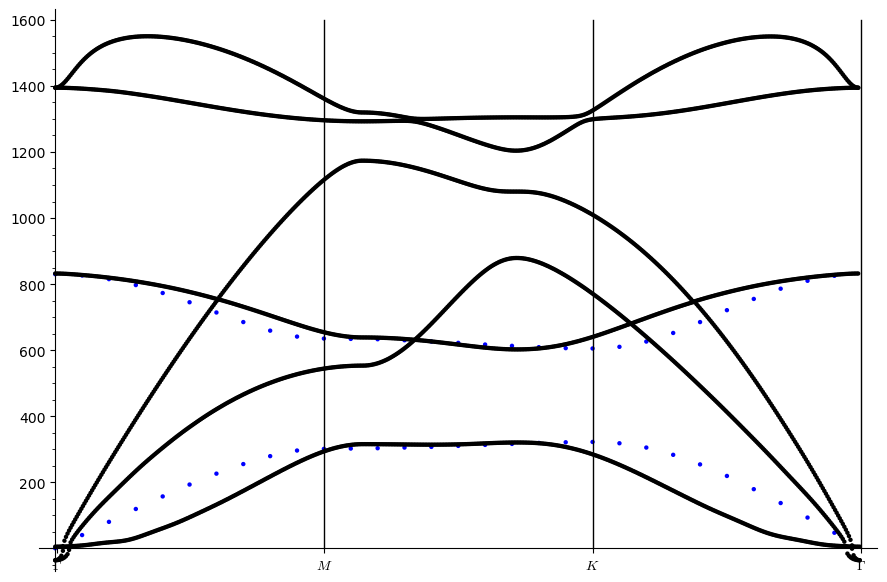

In [24]:
sol_perp_num3ers=Solucions3ers
show(\
list_plot(
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)] +\
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)]+\
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)]) + \
list_plot(
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]+
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1,q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]+\
    [round(real_part(n(sqrt(D_zz3ers.subs(sol_perp_num3ers, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]) \
     +line([(10,0),(10,1600)], color="black")+line([(20,0),(20,1600)], color="black")\
     +line([(30,0),(30,1600)], color="black", ticks=[[0.05,10,20,30], None], \
        tick_formatter = [[r'$\Gamma$', '$M$', '$K$', r'$\Gamma$'], None])+\
points(zip(dades[:524,0]/524*30, dades[:524,1]), color="black") +\
points(zip(dades[524:1048,0]/524*30, dades[524:1048,1]), color="black") +\
points(zip(dades[1048:1572,0]/524*30, dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0]/525*30, dades[1572:2096,1]), color="black") +\
points(zip(dades[2096:2620,0]/525*30, dades[2096:2620,1]), color="black") +\
points(zip(dades[2620:3144,0]/525*30, dades[2620:3144,1]), color="black")     
     ,figsize=9) 

### Fins 4ts veïns

#### Punt $\Gamma$

In [25]:
D_Gamma4ts_zz=D_zz4ts.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
D_Gamma4ts_zz.eigenvalues()
Eq_Gamma_ZO4ts=(D_Gamma4ts_zz.eigenvalues()[0]==omegaGammaZO**2)
show(Eq_Gamma_ZO4ts)

-6*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) == omegaGammaZO^2

In [26]:
norm(vector([D_zz4ts.subs(q_x=0.6,q_y=0.6,a=1).eigenvalues()[0].subs(valors_numerics_emprats),D_zz4ts.subs(q_x=1/2,q_y=1/2,a=1).eigenvalues()[1].subs(valors_numerics_emprats)]))
#minimize(norm(vector(Equacions3ers)),[1.,1.,1.,1.])

sqrt((1.0902764218292245e-05)*abs(14.0067*((((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/4*I*sqrt(3) - 13/4*I) + 1)*e^(1/4*I*sqrt(3) - 11/4*I) + e^(3/4*I*sqrt(3) - 11/4*I) + e^(3/4*I*sqrt(3) - 13/4*I) + e^(1/4*I*sqrt(3) - 13/4*I))*phi2toBB + 10.811*((((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/4*I*sqrt(3) - 13/4*I) + 1)*e^(1/4*I*sqrt(3) - 11/4*I) + e^(3/4*I*sqrt(3) - 11/4*I) + e^(3/4*I*sqrt(3) - 13/4*I) + e^(1/4*I*sqrt(3) - 13/4*I))*phi2toNN - 73.83326901336551*phi1toBN*e^(1/2*I*sqrt(3) - 3*I) - 73.83326901336551*phi3toBN*e^(1/2*I*sqrt(3) - 3*I) - 147.66653802673102*phi4toBN*e^(1/2*I*sqrt(3) - 3*I) + sqrt(605.7057348*(((e^(13/2*I) + e^(6*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 3/4*I))*e^(-1/4*I*sqrt(3) + 27/4*I) + (((e^(3/2*I) + e^(1/2*I))*e^(5*I) + 2*e^(6*I))*e^(5/2*I*sqrt(3) - 23*I) + (e^(4*I) + e^(7/2*I))*e^(9/4*I*sqrt(3) - 83/4*I))*e^(-5/2*I*sqrt(3) + 23*I))*phi1toBN^2 + 196.18764489*(2*((((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 22*I) + (((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 45/2*I))*e^(-21/4*I*sqrt(3) + 129/4*I) + ((((2*((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 13/2*I) + (2*(e^(3/2*I) + e^(1/2*I))*e^(2*I) - ((12*e^(3/2*I) + 12*e^(1/2*I) - 1)*e^(5*I) - e^(7*I) - 38*e^(6*I))*e^(1/4*I*sqrt(3) - 11/4*I) - 12*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + 2*e^(1/4*I*sqrt(3) - 15/4*I))*e^(1/2*I*sqrt(3) - 13/2*I) + e^(3/4*I*sqrt(3) - 39/4*I))*e^(1/2*I*sqrt(3) - 11/2*I) + e^(5/4*I*sqrt(3) - 65/4*I))*e^(17/4*I*sqrt(3) - 79/4*I) + e^(13/2*I*sqrt(3) - 35*I) + 2*e^(13/2*I*sqrt(3) - 71/2*I) + e^(13/2*I*sqrt(3) - 36*I) + 2*e^(6*I*sqrt(3) - 71/2*I) + 2*e^(6*I*sqrt(3) - 36*I))*e^(-6*I*sqrt(3) + 83/2*I))*phi2toBB^2 - 302.8528674*(4*((((e^(3/2*I) + e^(1/2*I))*e^(5*I) - 6*e^(6*I))*e^(I*sqrt(3) - 6*I) + e^(3/4*I*sqrt(3) + 1/4*I))*e^(-21/4*I*sqrt(3) + 129/4*I) + e^(-9/2*I*sqrt(3) + 32*I))*e^(9/2*I*sqrt(3) - 53/2*I) + 4*((e^(3/2*I) + e^(1/2*I))*e^(5*I) - 6*e^(6*I))*e^(-1/4*I*sqrt(3) + 1/4*I) - 2*((((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 22*I) + (((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 45/2*I) - 2*(((e^(3/2*I) + e^(1/2*I))*e^(5*I) - 6*e^(6*I))*e^(3/4*I*sqrt(3) - 25/4*I) + e^(1/2*I*sqrt(3)))*e^(19/4*I*sqrt(3) - 103/4*I))*e^(-21/4*I*sqrt(3) + 129/4*I) + (4*((e^(3/2*I) + e^(1/2*I))*e^(3*I) - 6*e^(4*I))*e^(23/4*I*sqrt(3) - 159/4*I) - (((2*(e^(3/2*I) + e^(1/2*I))*e^(2*I) + ((12*e^(3/2*I) + 12*e^(1/2*I) - 1)*e^(5*I) - e^(7*I) - 38*e^(6*I))*e^(1/4*I*sqrt(3) - 11/4*I) - 12*e^(3*I))*e^(7/4*I*sqrt(3) - 39/4*I) + 2*(((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 13/2*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5/4*I*sqrt(3) - 11/4*I))*e^(1/2*I*sqrt(3) - 13/2*I) + e^(2*I*sqrt(3) - 25/2*I))*e^(7/2*I*sqrt(3) - 45/2*I) + e^(13/2*I*sqrt(3) - 35*I) + 2*e^(13/2*I*sqrt(3) - 71/2*I) + e^(13/2*I*sqrt(3) - 36*I) + 2*e^(6*I*sqrt(3) - 71/2*I) - 2*e^(6*I*sqrt(3) - 36*I) + 2*e^(11/2*I*sqrt(3) - 35*I) + 4*e^(11/2*I*sqrt(3) - 71/2*I) + e^(11/2*I*sqrt(3) - 36*I))*e^(-6*I*sqrt(3) + 83/2*I))*phi2toBB*phi2toNN + 116.877721*(2*((((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 22*I) + (((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + e^(1/4*I*sqrt(3) - 15/4*I))*e^(5*I*sqrt(3) - 45/2*I))*e^(-21/4*I*sqrt(3) + 129/4*I) + ((((2*((e^(3/2*I) + e^(1/2*I))*e^(2*I) - 6*e^(3*I))*e^(1/2*I*sqrt(3) - 13/2*I) + (2*(e^(3/2*I) + e^(1/2*I))*e^(2*I) - ((12*e^(3/2*I) + 12*e^(1/2*I) - 1)*e^(5*I) - e^(7*I) - 38*e^(6*I))*e^(1/4*I*sqrt(3) - 11/4*I) - 12*e^(3*I))*e^(1/2*I*sqrt(3) - 7*I) + 2*e^(1/4*I*sqrt(3) - 15/4*I))*e^(1/2*I*sqrt(3) - 13/2*I) + e^(3/4*I*sqrt(3) - 39/4*I))*e^(1/2*I*sqrt(3) - 11/2*I) + e^(5/4*I*sqrt(3) - 65/4*I))*e^(17/4*I*sqrt(3) - 79/4*I) + e^(13/

#### Punt $M$

In [27]:
D_M4ts_zz=D_zz4ts.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

# Podem simplificar un poc l'expressió obtessa per als valores propios al punto $M$ 
#(simplement reescribint l'argument de l'arrel quadrada)

assume(sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)>0)

omegaM1quadrat4ts=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN+2*phi4toBN)\
   -sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)/(M_B*M_N)

if bool(D_M4ts_zz.eigenvalues()[0]==omegaM1quadrat4ts):
    Eq_M_ZA4ts=(omegaM1quadrat4ts==omegaMZA**2)



omegaM2quadrat4ts=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN+2*phi4toBN)\
   +sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)/(M_B*M_N)

if bool(D_M4ts_zz.eigenvalues()[1]==omegaM2quadrat4ts):
    Eq_M_ZO4ts=(omegaM2quadrat4ts==omegaMZO**2)
    
    
show(Eq_M_ZA4ts)
show(Eq_M_ZO4ts)

#Eq_M_ZOmesZA4ts=(Eq_M_ZO4ts+Eq_M_ZA4ts).subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
#show(Eq_M_ZOmesZA4ts)
#Eq_M_ZOmenysZA4ts_quadrat=((Eq_M_ZO4ts-Eq_M_ZA4ts)**2).subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
#show(Eq_M_ZOmenysZA4ts_quadrat)

-3*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 4*M_B*M_N*(phi1toBN - 3*phi3toBN + phi4toBN)*phi4toBN + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZA^2

-3*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 4*M_B*M_N*(phi1toBN - 3*phi3toBN + phi4toBN)*phi4toBN + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZO^2

#### Punt $K$

In [28]:
omega_K_ZO=605 #cm-1
omega_K_ZA=322
D_K_zz4ts=D_zz4ts.subs(q_x=4*pi/(3*a),q_y=0)

Eq_K_ZA4ts=(D_K_zz4ts.eigenvalues()[0]==omegaKZA**2).expand() #.subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
Eq_K_ZO4ts=(D_K_zz4ts.eigenvalues()[1]==omegaKZO**2).expand() #.subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()

#Eq_K_ZOmesZA3ers=Eq_K_ZA3ers+Eq_K_ZO3ers

#Eq_K_ZOmenysZA3ers=Eq_K_ZA3ers-Eq_K_ZO3ers

show(Eq_K_ZA4ts)
show(Eq_K_ZO4ts)

-3*phi1toBN/(sqrt(M_B)*sqrt(M_N)) - 9*phi2toNN/M_N - 3*phi3toBN/(sqrt(M_B)*sqrt(M_N)) - 6*phi4toBN/(sqrt(M_B)*sqrt(M_N)) == omegaKZA^2

-3*phi1toBN/(sqrt(M_B)*sqrt(M_N)) - 9*phi2toBB/M_B - 3*phi3toBN/(sqrt(M_B)*sqrt(M_N)) - 6*phi4toBN/(sqrt(M_B)*sqrt(M_N)) == omegaKZO^2

Si considerem fins a 4ts veïns no trobem una solució analítica, així que substituïm les variables conegudes pels seus valors numèrics:

In [29]:
Equacions4ts=[Eq_Gamma_ZO4ts.subs(valors_numerics_emprats),Eq_M_ZO4ts.subs(valors_numerics_emprats),Eq_M_ZA4ts.subs(valors_numerics_emprats),\
               Eq_K_ZO4ts.subs(valors_numerics_emprats),Eq_K_ZA4ts.subs(valors_numerics_emprats)]
solucions4ts=minimize(norm(vector((Equacions4ts))),[-1400000.,1.,1.,1.,1.])
Solucions4ts=[phi1toBN==round(solucions4ts[0]), phi2toBB==round(solucions4ts[1]),\
              phi2toNN==round(solucions4ts[2]), phi3toBN==round(solucions4ts[3]),\
              phi4toBN==round(solucions4ts[4])]
Solucions4ts

[phi1toBN == -1392307,
 phi2toBB == -28078,
 phi2toNN == 371904,
 phi3toBN == -51841,
 phi4toBN == 15387]

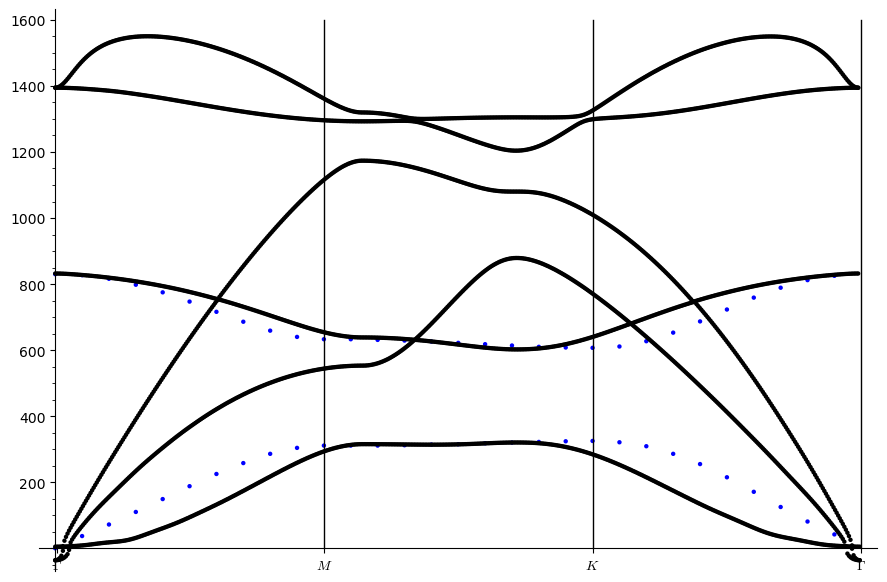

In [30]:
sol_perp_num4tsn=Solucions4ts
show(\
list_plot(
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)] +\
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)]+\
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[1])))) \
        for x in srange(0,1,0.1)]) + \
list_plot(
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(x*pi), q_y=n(x*pi/sqrt(3))).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]+
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1,q_x=n(pi*(1+x/3)), q_y=n(pi/sqrt(3)*(1-x))).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]+\
    [round(real_part(n(sqrt(D_zz4ts.subs(sol_perp_num4tsn, M_B=B.mass, \
        M_N=N.mass, a=1, q_x=n(4*pi/3*(1-x)), q_y=0).simplify_full().eigenvalues()[0])))) \
        for x in srange(0,1,0.1)]) \
     +line([(10,0),(10,1600)], color="black")+line([(20,0),(20,1600)], color="black")\
     +line([(30,0),(30,1600)], color="black", ticks=[[0.05,10,20,30], None], \
        tick_formatter = [[r'$\Gamma$', '$M$', '$K$', r'$\Gamma$'], None])+\
points(zip(dades[:524,0]/524*30, dades[:524,1]), color="black") +\
points(zip(dades[524:1048,0]/524*30, dades[524:1048,1]), color="black") +\
points(zip(dades[1048:1572,0]/524*30, dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0]/525*30, dades[1572:2096,1]), color="black") +\
points(zip(dades[2096:2620,0]/525*30, dades[2096:2620,1]), color="black") +\
points(zip(dades[2620:3144,0]/525*30, dades[2620:3144,1]), color="black")     
     ,figsize=9) 

| Serie | Color  | Punt  | $\omega$ |    Rama |
|-------|--------|-------|----------|---------|
|     1 | Roig   | $\Gamma$ |       0    |  1 (ZA) |
|     1 | Roig   | M     |        314    | 1 (ZA) |
|     1 | Roig   | K     |       320     |1 (ZA) |
|     2 | Marro  | $\Gamma$ |       0    |2 (TA) |
|     2 | Marro  | M     |           553 |2 (TA) |
|     2 | Marro  | K     |           602 | 4 (ZO) |
|     3 | Negre  | $\Gamma$ |         4  | 3 (LA) |
|     3 | Negre  | M     |           638 | 4 (ZO) |
|     3 | Negre  | K     |           878 |     2(TA) |
|     4 | Rosa   | $\Gamma$ |        831 |  4 (ZO) |
|     4 | Rosa   | M     |          1173 |       3 (LA) |
|     4 | Rosa   | K     |          1080 |       3 (LA) |
|     5 | B.clar | $\Gamma$ |       1394 |       5 (TO) |
|     5 | B.clar | M     |          1292 |       5 (TO)|
|     5 | B.clar | K     |          1204 |       5 (TO)|
|     6 | Blau   | $\Gamma$ |       1394 |       6 (LO)|
|     6 | Blau   | M     |          1320 |       6 (LO)|
|     6 | Blau   | K     |          1304 |       6 (LO)|

## Vibracions al pla del cristall

Vibracions dins del pla del cristall
En este cas tractem amb una matriu $4\times 4$, i per tant tenim 4 valors propis ($\omega^2$) en cada punt $q_x$, $q_y$, que corresponen a cuatre rames.

In [31]:
D1BN_xy=D1BN.matrix_from_rows_and_columns([0,1],[0,1])
D1NB_xy=D1NB.matrix_from_rows_and_columns([0,1],[0,1])

D2BB3ers_xy=D2BB3ers.matrix_from_rows_and_columns([0,1],[0,1])
D2NN3ers_xy=D2NN3ers.matrix_from_rows_and_columns([0,1],[0,1])

D2BB4ts_xy=D2BB4ts.matrix_from_rows_and_columns([0,1],[0,1])
D2NN4ts_xy=D2NN4ts.matrix_from_rows_and_columns([0,1],[0,1])


D3BN_xy=D3BN.matrix_from_rows_and_columns([0,1],[0,1])
D3NB_xy=D3NB.matrix_from_rows_and_columns([0,1],[0,1])
D4BN_xy=D4BN.matrix_from_rows_and_columns([0,1],[0,1])
D4NB_xy=D4NB.matrix_from_rows_and_columns([0,1],[0,1])

#D_xy=block_matrix([[D2BB_xy, D1BN_xy+D3BN_xy+D4BN_xy],[D1NB_xy+D3NB_xy+D4NB_xy, D2NN_xy]])
D3ers_xy=block_matrix([[D2BB3ers_xy, D1BN_xy+D3BN_xy],[D1NB_xy+D3NB_xy, D2NN3ers_xy]])

D4ts_xy=block_matrix([[D2BB4ts_xy, D1BN_xy+D3BN_xy+D4BN_xy],[D1NB_xy+D3NB_xy+D4NB_xy, D2NN4ts_xy]])

### Considerem sols fins als 3ers veïns

#### Al punt $\Gamma$

Fins 3ers veïns

Al punt $\Gamma$ obtinc 2 valors propis, de multiplicitat $2$ cadascun:

In [32]:
omega_Gamma_TO=1394
D_Gamma3ers_xy=D3ers_xy.subs(q_x=0,q_y=0)

show([D_Gamma3ers_xy.eigenvalues()[0], D_Gamma3ers_xy.eigenvalues()[2]])
 

[-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N), 0]

De manera que obtenim les següents equacions:

In [33]:
#Eq_Gamma_LA3ers=solve(D_Gamma_xy.eigenvalues()[2]==0,phi4tiBN)[0]
#D_Gamma3ers_xy=D_xy.subs(q_x=0,q_y=0).subs(Eq_Gamma_LA)

#show([D_Gamma_xy.eigenvalues()[0], D_Gamma_xy.eigenvalues()[2]])

omega_Gamma_TO=1394
Eq_Gamma_TO3ers=(D_Gamma3ers_xy.eigenvalues()[0]==omegaGammaTO**2)
#show(Eq_Gamma_LA)
show(Eq_Gamma_TO3ers)

-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N) == omegaGammaTO^2

```{note}
Per als punts $K$ i $M$, sagemath (mitjançant [maxima](https://maxima.sourceforge.io/)) no obté una expressió analítica però si supossem que els 2 àtoms de la base tenen la mateixa massa  ($M_N=M_B$) podem obtindre fàcilment els valors propis de la matriu original realitzant les substitucions pertinents als resultats obtessos
```

### Al punt $M$
En ($q_x=\pi/a,q_y=\pi/(\sqrt{3} a$)

In [34]:
D_M3ers_xy=D3ers_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

D_M3ers_xy_simplificada=D_M3ers_xy.subs(M_N=M_B)

Valors_propis_M3ers=D_M3ers_xy_simplificada.eigenvalues()

Valors_propis_en_M3ers=[M_B*Valors_propis_M3ers[i].subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B),) for i in range(4)]
    #phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)

omega_M_LO=1320
omega_M_TO=1292

omega_M_LA=1173
omega_M_TA=553
#Comprobem que sí són els valors propis:
#[det(D_M_xy-Valors_propis_en_M[i]) for i in range(4)]


#for i in range(4):
#    show(Valors_propis_en_M3ers[i].expand())

Obtenim  4 valors propis amb arrels quadrades amb molts termes, deduirem unes altres 
expressions a partir d'estes més sencilles i intentarem obtindre relacions entre els valors de les constants per a segons veïns d'elles.

Podem observar que els valors propis en M 0 i 1 (així com 2 i 3) difereixen en una arrel quadrada (negativa i per tant amb valor propi corresponent menor per a 0 i 2).
Per una altra banda els termes de fora de l'arrel sols difereixen en 2 i 3 respecte els de 1 i 2 que els termes $\phi_{2,r}$ ($BB$ i $NN$) van multiplicats pel factor 3 en el cas de $2$ i $3$ mentre que en $0$ i $1$ son els termes $\phi_{2,ti}$ els que van multiplicats per 3.

Supossant que les constants de força radials són més grans que les transversals per assignar cada valor propi a cada rama, puc concloure que els dos primers valors propis corresponen al menor i al major respectivament. Els 3 i 4ts don intermijos, essent el 4t major que el tercer, per tant

In [35]:
Eq_M_TA3ers = (Valors_propis_en_M3ers[0].expand() == omegaMTA^2)
Eq_M_LO3ers = (Valors_propis_en_M3ers[1].expand() == omegaMLO^2)
Eq_M_LA3ers = (Valors_propis_en_M3ers[2].expand() == omegaMLA^2)
Eq_M_TO3ers = (Valors_propis_en_M3ers[3].expand() == omegaMTO^2)


#Eq_M_TA = (Valors_propis_en_M[0].subs(Eq_Gamma_LA).expand() == omegaMTA^2)
#Eq_M_LO = (Valors_propis_en_M[1].subs(Eq_Gamma_LA).expand() == omegaMLO^2)
#Eq_M_TO = (Valors_propis_en_M[2].subs(Eq_Gamma_LA).expand() == omegaMTO^2)
#Eq_M_LA = (Valors_propis_en_M[3].subs(Eq_Gamma_LA).expand() == omegaMLA^2)

show(Eq_M_LO3ers)
show(Eq_M_TO3ers)
show(Eq_M_LA3ers)
show(Eq_M_TA3ers)
#Eq_M_TA_mes_M_LO3ers=(Eq_M_TA3ers + Eq_M_LO3ers)
#show(Eq_M_TA_mes_M_LO3ers)
#Eq_M_LA_mes_M_TO3ers=(Eq_M_LA3ers + Eq_M_TO3ers)
#show(Eq_M_LA_mes_M_TO3ers)
#Eq_M_LO_menys_TA3ers_quadrat=((Eq_M_LO3ers-Eq_M_TA3ers)**2).expand()
#show(Eq_M_LO_menys_TA3ers_quadrat)
#Eq_M_TO_menys_LA3ers_quadrat=((Eq_M_TO3ers-Eq_M_LA3ers)**2).expand()
#show(Eq_M_TO_menys_LA3ers_quadrat)
#Fem notar que la suma de tots els valors propis en $M$ compleix l'equació:
#(3*Eq_M_LA_mes_M_TO3ers-Eq_M_TA_mes_M_LO3ers).subs(solve(Eq_Gamma_TO3ers,phi3rBN)).expand()
#(Eq_M_LA_mes_M_TO-3*Eq_M_TA_mes_M_LO).subs(solve(Eq_Gamma_TO,phi3rBN)).expand()

1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMLO^2

1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMTO^2

-1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMLA^2

-1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMTA^2

### Al punt $K$ 
En $\left(k_x=\frac{4\pi}{3a}, k_y=0\right)$

In [36]:
omega_K_LO=1304
omega_K_LA=1080
omega_K_TA=553

omega_K_TO=sqrt(omega_K_LO**2+omega_K_TA**2-omega_K_LA)

D_K3ers_xy=D3ers_xy.subs(q_x=4*pi/(3*a),q_y=0)# phi4tiBN=-phi4rBN)
D_K3ers_xy_simplificada=D_K3ers_xy.subs(M_N=M_B)
Valors_propis_K3ers=D_K3ers_xy_simplificada.eigenvalues()

Valors_propis_en_K3ers=[M_B*Valors_propis_K3ers[i].expand().subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B)) for i in range(4)]
    #phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)) for i in range(4)]

#Comprobem que sí són els valors propis:
#[det(D_K_xy-Valors_propis_en_K[i]) for i in range(4)]
for i in range(4):
    show(Valors_propis_en_K3ers[i].expand())

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rNN/M_N - 9/2*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rBB/M_B - 9/2*phi2tiBB/M_B - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

Emprant un argument anàleg a l'emprat per als valors propis en $M$ assignem cada valor propi a cadascuna de les rames, de manera que:

In [37]:
Eq_K_LA3ers = (Valors_propis_en_K3ers[0].subs(Eq_Gamma_TO3ers.solve(phi3tiBN)).expand() == omegaKLA^2)
Eq_K_TO3ers = (Valors_propis_en_K3ers[1].subs(Eq_Gamma_TO3ers.solve(phi3tiBN)).expand() == omegaKTO^2)
Eq_K_TA3ers = (Valors_propis_en_K3ers[2].subs(Eq_Gamma_TO3ers.solve(phi3tiBN)).expand() == omegaKTA^2)
Eq_K_LO3ers = (Valors_propis_en_K3ers[3].subs(Eq_Gamma_TO3ers.solve(phi3tiBN)).expand() == omegaKLO^2)

Eq_KTA_mes_KLO3ers=(Eq_K_TA3ers + Eq_K_LO3ers)
Eq_KLA_mes_KTO3ers=(Eq_K_LA3ers + Eq_K_TO3ers)

show(Eq_K_LA3ers)
show(Eq_K_TO3ers)
show(Eq_K_TA3ers)
show(Eq_K_LO3ers)

Eq_KLO_menys_KTA_quadrat3ers=((Eq_K_LO3ers-Eq_K_TA3ers)**2).expand()
Eq_KTO_menys_KLA_quadrat3ers=((Eq_K_TO3ers-Eq_K_LA3ers)**2).expand()
#show(Eq_K_LA3ers.subs(constants).expand())
#show(Eq_K_TO3ers.subs(constants).expand())

#show(Eq_KLA_mes_KTO3ers.expand())
#show(Eq_KTA_mes_KLO3ers.expand())
#show(Eq_KLO_menys_KTA_quadrat3ers)
#show(Eq_KTO_menys_KLA_quadrat3ers)

1/2*omegaGammaTO^2 - 9/2*phi2rNN/M_N - 9/2*phi2tiNN/M_N == omegaKLA^2

1/2*omegaGammaTO^2 - 9/2*phi2rBB/M_B - 9/2*phi2tiBB/M_B == omegaKTO^2

1/2*omegaGammaTO^2 - 1/4*sqrt(4*omegaGammaTO^4 + 48*omegaGammaTO^2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) + 48*omegaGammaTO^2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) + 144*phi1rBN^2/(M_B*M_N) + 81*phi2rBB^2/M_B^2 - 162*phi2rBB*phi2rNN/(M_B*M_N) + 81*phi2rNN^2/M_N^2 + 162*phi2rBB*phi2tiBB/M_B^2 - 162*phi2rNN*phi2tiBB/(M_B*M_N) + 81*phi2tiBB^2/M_B^2 - 162*phi2rBB*phi2tiNN/(M_B*M_N) + 162*phi2rNN*phi2tiNN/M_N^2 - 162*phi2tiBB*phi2tiNN/(M_B*M_N) + 81*phi2tiNN^2/M_N^2 + 288*phi1rBN*phi3rBN/(M_B*M_N) + 144*phi3rBN^2/(M_B*M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N == omegaKTA^2

1/2*omegaGammaTO^2 + 1/4*sqrt(4*omegaGammaTO^4 + 48*omegaGammaTO^2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) + 48*omegaGammaTO^2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) + 144*phi1rBN^2/(M_B*M_N) + 81*phi2rBB^2/M_B^2 - 162*phi2rBB*phi2rNN/(M_B*M_N) + 81*phi2rNN^2/M_N^2 + 162*phi2rBB*phi2tiBB/M_B^2 - 162*phi2rNN*phi2tiBB/(M_B*M_N) + 81*phi2tiBB^2/M_B^2 - 162*phi2rBB*phi2tiNN/(M_B*M_N) + 162*phi2rNN*phi2tiNN/M_N^2 - 162*phi2tiBB*phi2tiNN/(M_B*M_N) + 81*phi2tiNN^2/M_N^2 + 288*phi1rBN*phi3rBN/(M_B*M_N) + 144*phi3rBN^2/(M_B*M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N == omegaKLO^2

In [38]:
valors_numerics_pla_emprats=[omegaGammaTO==omega_Gamma_TO,\
                             omegaMLO==omega_M_LO,\
                             omegaMTO==omega_M_TO,\
                             omegaMLA==omega_M_LA,\
                             omegaMTA==omega_M_TA,\
                             omegaKLO==omega_K_LO,\
                             omegaKTO==omega_K_TO,\
                             omegaKLA==omega_K_LA,\
                             omegaKTA==omega_K_TO,\
                             M_B==B.mass, M_N==N.mass \
                            ]
Equacionspla3ers=[Eq_Gamma_TO3ers.subs(valors_numerics_pla_emprats),
                  Eq_M_LO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_TO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_LA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_TA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_LO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_TO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_LA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_TA3ers.subs(valors_numerics_pla_emprats)]
solucionspla3ers=minimize(norm(vector((Equacionspla3ers))),[1.,1.,1.,1.,1.,1.,1.,1.])
Solucionspla3ers=[phi1rBN==round(solucionspla3ers[0]),\
                  phi1tiBN==round(solucionspla3ers[1]),\
                  phi2rBB==round(solucionspla3ers[2]),\
                  phi2tiBB==round(solucionspla3ers[3]),\
                  phi2rNN==round(solucionspla3ers[4]),\
                  phi2tiNN==round(solucionspla3ers[5]),\
                  phi3rBN==round(solucionspla3ers[6]),\
                  phi3tiBN==round(solucionspla3ers[7])]
                  
Solucionspla3ers

[phi1rBN == 571942,
 phi1tiBN == -4145416,
 phi2rBB == -1054848,
 phi2tiBB == -2346249,
 phi2rNN == -784388,
 phi2tiNN == 794454,
 phi3rBN == -4557368,
 phi3tiBN == 1226866]

In [39]:
u,v=numpy.linalg.eig(D3ers_xy.subs(Solucionspla3ers, M_B=B.mass, M_N=N.mass, a=1, q_x=n(pi), q_y=n(pi/sqrt(3))).numpy(dtype='complex64'))
sqrt(round(u))

array([1597.7416 +0.j, 1370.9395 +0.j,  631.928  -0.j, 1022.59863+0.j],
      dtype=complex64)

In [40]:
v

array([[-0.4745159 -2.4558632e-17j,  0.85640186+0.0000000e+00j,
         0.15759018+5.1120665e-17j,  0.12874727-1.1101456e-17j],
       [ 0.82188565+0.0000000e+00j,  0.49444383-3.5242047e-17j,
        -0.2729542 -3.6953675e-17j,  0.07433227+8.0911052e-18j],
       [-0.15759018+5.0740205e-17j, -0.12874727-1.1516696e-17j,
        -0.47451591+2.5669597e-17j,  0.85640186+0.0000000e+00j],
       [ 0.2729542 -3.7386353e-17j, -0.07433228+8.6619161e-18j,
         0.82188565+0.0000000e+00j,  0.49444386+3.6229211e-17j]],
      dtype=complex64)

In [41]:
#[D3ers_xy.subs(Solucionspla3ers, M_B=B.mass, M_N=N.mass, a=1).numpy() for (q_x=0.0, q_y=0)]

{% bibliography %}